In [109]:
using DataFrames,CSV,LinearAlgebra,Optim,StatsBase,CSV,PythonPlot
include("./../GP.jl")
include("./../LineageAnalysisTools.jl")

FIG_PATH = "./../figures"

"./../figures"

I use this notebook to tinker with the Gaussian process procedure

In [110]:
 # 1: LOAD PROCESSED DATA -----------------------------------------------------------------------------------------------
data_src = "/Users/elevien/Dropbox (Dartmouth College)/RESEARCH/L1210_growth_rate_fluctuations/experimental_data/processed_data/traceupdated.csv"

data = CSV.read("./../output/data_processed.csv",DataFrames.DataFrame);
data = data[(data.length .> 10),:];
lineages = unique(data.lineage)
data[:,:y] = data[:,:lnM_sum]

75424-element Vector{Float64}:
  3.837336528
  3.841039225
  3.840495424
  3.842358408
  3.841767051
  3.842767671
  3.844473449
  3.84642152
  3.848348111
  3.848694206
  ⋮
 16.63821607
 16.64018474
 16.64411103
 16.64054755
 16.64135095
 16.64721359
 16.63961652
 16.64517917
 16.64658204

In [111]:
df = data[data.lineage .== lineages[1],:];
df[:,:gen_time]= vcat([ones(length(df[df.position .==p,:].time))*(df[df.position .==p,:].time[end]-df[df.position .==p,:].time[1])
        for p in unique(df.position)]...);
df = df[df.cellcycle .=="i",:];

# make input array for optimization ----------------------------------------
X = Array(df[:,[:time,:age_normed,:position]]); # predictor matrix
Tb = push!([min(data[data.position .== p,:time]...) for p in unique(data.position)],data[end,:time]); # birth times
X =  hcat(X,hcat([Tb for k in 1:length(X[:,1])]...)',df.position); # add generations times to predictor array
model = LineageAnalysisTools.Matern32Model()
M = zeros(length(df[:,:time]),length(df[:,:time]));

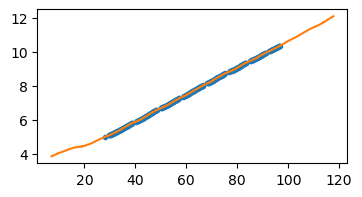

In [130]:
ops = Optim.Options(g_tol = 1e-5,iterations = 1000,store_trace = true,show_trace = false);
pred_df = uniform_prediction_array(df,0.1) # this is the array of values to make predictions at
opt_inds = 1000:10:min(4000,length(df.time))  # these are the indices used to by the optimizer
obs_inds = 1:20:length(df.time) # these are the indices used to make predictions (the actual function being smoothed)

fig, ax = subplots(figsize=(4,2))
ax.plot(df.time[opt_inds],df.y[opt_inds],".")
ax.plot(df.time,df.y,"-")
#ax.set_xlim([df.time[1],25])
fig

In [131]:
cd(dirname(@__FILE__))
folder = pwd()*"../output/output_7-23-24/lineage_TEST"
mkpath(folder)
@time output = gp_predict(df,model,opt_inds,obs_inds,pred_df)

 34.058795 seconds (795.17 M allocations: 78.335 GiB, 14.21% gc time)
  0.796291 seconds (15.38 M allocations: 2.102 GiB, 14.77% gc time)
 35.684642 seconds (810.60 M allocations: 80.442 GiB, 13.89% gc time, 2.32% compilation time)


(1106×11 DataFrame
  Row │ matern32_cell  matern32_cell_var  matern32_cell_x  matern32_cell_x_var ⋯
      │ Float64        Float64            Float64          Float64             ⋯
──────┼─────────────────────────────────────────────────────────────────────────
    1 │   0.00141137         0.000299217      -0.0848003           -0.00377364 ⋯
    2 │   0.000465211        0.000298956      -0.0854509           -0.00383236
    3 │  -0.000486249        0.000298589      -0.0857531           -0.00388013
    4 │  -0.00143909         0.000298117      -0.085699            -0.00391811
    5 │  -0.00238933         0.000297544      -0.0852827           -0.00394748 ⋯
    6 │  -0.00333291         0.000296876      -0.0845004           -0.00396947
    7 │  -0.00426575         0.000296124      -0.0833506           -0.00398526
    8 │  -0.00518378         0.000295299      -0.081834            -0.003996
  ⋮   │       ⋮                ⋮                 ⋮                  ⋮          ⋱
 1100 │   0.0114451    

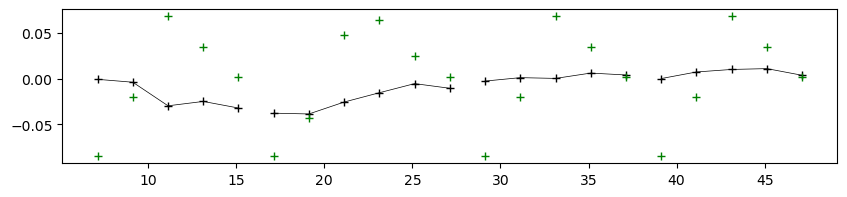

In [128]:
fig, ax= subplots(figsize=(10,2))
df_out = output[1]
for p in unique(df_out.position)[1:4]
    ax.plot(df_out[df_out.position .==p,:time],df_out[df_out.position .==p,:matern32_flucs_x],"k+-",lw=0.5)
    ax.plot(df_out[df_out.position .==p,:time],df_out[df_out.position .==p,:matern32_cell_x],"g+",lw=0.5)
end
fig

In [133]:
CSV.write("./TEST.csv",output[1])

"./TEST.csv"